In [ ]:
#@title WhatsApp Chat Analyzer
#@markdown 1. Run this cell to install necessary libraries.
#@markdown 2. After it finishes, an "Upload" button will appear.
#@markdown 3. Click the button and upload your WhatsApp chat ZIP file.
#@markdown 4. The analysis and dashboard will be generated below.

# Install necessary libraries
!pip install -q pandas plotly matplotlib wordcloud textblob_de vaderSentiment emoji nltk langdetect indic-nlp-library

import re
import pandas as pd
import plotly.express as px
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import zipfile
import io
from google.colab import files
import os
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import emoji
from datetime import datetime # Import datetime class
import nltk
from nltk.corpus import stopwords
from langdetect import detect, LangDetectException


# Download nltk stop words
nltk.download('stopwords', quiet=True)


# --- Function to parse the WhatsApp chat file ---
def parse_whatsapp_chat(file_content):
    """
    Parses a WhatsApp chat text file into a pandas DataFrame.
    Handles different date/time formats and multi-line messages.
    """
    lines = file_content.split('\n')
    messages = []
    message_buffer = []
    timestamp = None # Initialize timestamp to None
    # Updated regex to be more flexible with potential variations in date/time/separator
    date_time_pattern = re.compile(r'^\[?(\d{1,2}/\d{1,2}/\d{2,4}),?\s*(\d{1,2}:\d{2}(?::\d{2})?(?:\s*[AP]M)?)\]?\s*[-–]\s*([^:]+?):\s*(.*)$')


    for line in lines:
        match = date_time_pattern.match(line)
        if match:
            if message_buffer and timestamp is not None:
                full_message = " ".join(message_buffer).strip()
                # Ensure there's a colon before splitting
                if ':' in full_message:
                    author, msg = full_message.split(':', 1)
                    messages.append([timestamp, author.strip(), msg.strip()])
                message_buffer = []

            date_s, time_s, user, msg = match.groups()
            timestamp_str = f"{date_s} {time_s}".strip()
            ts = None
            # Adding more robust date format parsing
            fmts = [
                "%d/%m/%y %I:%M %p", "%m/%d/%y %I:%M %p",
                "%d/%m/%Y %I:%M %p", "%m/%d/%Y %I:%M %p",
                "%d/%m/%y %H:%M", "%m/%d/%y %H:%M",
                "%d/%m/%Y %H:%M", "%m/%d/%Y %H:%M",
                "%d/%m/%y %I:%M:%S %p", "%m/%d/%y %I:%M:%S %p",
                "%d/%m/%Y %I:%M:%S %p", "%m/%d/%Y %I:%M:%S %p",
                "%d/%m/%y %I:%M", "%m/%d/%y %I:%M",
                "%d/%m/%Y %I:%M", "%m/%d/%Y %I:%M",
            ]
            for fmt in fmts:
                try:
                    # Replace variations of am/pm to standardize for parsing
                    ts = datetime.strptime(timestamp_str.replace("am","AM").replace("pm","PM"), fmt)
                    break
                except ValueError:
                    pass # Try next format

            timestamp = ts
            message_buffer.append(f"{user}: {msg}") # Add the current message to the buffer

        else:
            # It's a continuation of the previous message
            message_buffer.append(line)

    # Add the last message in the buffer
    if message_buffer and timestamp is not None:
        full_message = " ".join(message_buffer).strip()
        if ':' in full_message:
            author, msg = full_message.split(':', 1)
            messages.append([timestamp, author.strip(), msg.strip()])

    df = pd.DataFrame(messages, columns=['timestamp', 'author', 'message'])
    # Remove media messages and messages that are only links
    df = df[df['message'] != '<Media omitted>']
    df = df[~df['message'].str.fullmatch(r'https?://\S+', na=False)] # Remove messages that are only links
    df = df.dropna(subset=['timestamp', 'author', 'message']) # Drop rows with any missing essential data

    print(f"Parsed {len(df)} messages.") # Add print statement to check parsed messages
    return df

# --- Function for Sentiment Analysis ---
def analyze_sentiment(df):
    """
    Performs sentiment analysis on the messages in the DataFrame.
    Uses VADER for English and a simple TextBlob approach for mixed language.
    """
    if df.empty:
        print("DataFrame is empty. Skipping sentiment analysis.")
        return df

    analyzer = SentimentIntensityAnalyzer()
    sentiments = []
    for message in df['message']:
        detected_lang = 'en' # Default to English
        try:
            if isinstance(message, str) and message.strip(): # Ensure message is a non-empty string
                detected_lang = detect(message)
        except LangDetectException:
            pass # Use default 'en' if detection fails

        if detected_lang == 'en':
            # VADER for English sentiment
            final_score = analyzer.polarity_scores(message)['compound']
        elif detected_lang == 'hi':
            # TextBlob for Hindi sentiment (as a fallback)
            # TextBlob's sentiment for non-English is not highly accurate
            # but serves as a placeholder if a dedicated Hindi library isn't used
            try:
                blob_polarity = TextBlob(message).sentiment.polarity
                final_score = blob_polarity
            except Exception:
                 final_score = 0 # Default to neutral if TextBlob fails
        else:
             # For other languages, use TextBlob as a general fallback
             try:
                blob_polarity = TextBlob(message).sentiment.polarity
                final_score = blob_polarity
             except Exception:
                final_score = 0 # Default to neutral if TextBlob fails


        if final_score > 0.05:
            sentiments.append('Positive')
        elif final_score < -0.05:
            sentiments.append('Negative')
        else:
            sentiments.append('Neutral')
    df['sentiment'] = sentiments
    return df

# --- Function to generate and display the dashboard ---
def generate_dashboard(df):
    """
    Generates and displays the dashboard components using Plotly and Matplotlib.
    """
    if df.empty:
        print("No messages parsed. Cannot generate dashboard.")
        return

    print("--- WhatsApp Chat Analysis Dashboard ---")
    print("\n")

    # --- KPIs ---
    total_messages = len(df)
    total_participants = df['author'].nunique()
    # Check if there are any authors before finding the mode
    if not df['author'].mode().empty:
        most_active_user = df['author'].mode()[0]
        print(f"Total Messages: {total_messages}")
        print(f"Total Participants: {total_participants}")
        print(f"Most Active User: {most_active_user}")
    else:
        print("No authors found in the parsed messages.")
    print("\n" + "="*40 + "\n")


    # --- Sentiment Analysis Visualization ---
    sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100
    fig_sentiment = px.bar(sentiment_counts,
                           x=sentiment_counts.index, y=sentiment_counts.values,
                           color=sentiment_counts.index,
                           labels={'x': 'Sentiment', 'y': 'Percentage (%)'},
                           title='Overall Sentiment Distribution',
                           color_discrete_map={'Positive':'green', 'Negative':'red', 'Neutral':'grey'})
    fig_sentiment.show()


    # --- Word Cloud ---
    text = " ".join(review for review in df.message)
    # Remove emojis and non-alphanumeric characters, convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text.lower())
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    text = " ".join(filtered_words)

    if text: # Generate word cloud only if there is text
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title('Most Frequent Words')
        plt.axis("off")
        plt.show()
    else:
        print("No text data to generate word cloud.")


    # --- Most Active Users ---
    if not df['author'].empty: # Check if there are authors before plotting
        top_5_users = df['author'].value_counts().nlargest(5)
        fig_users = px.bar(top_5_users,
                           x=top_5_users.values, y=top_5_users.index,
                           orientation='h',
                           labels={'x': 'Number of Messages', 'y': 'User'},
                           title='Top 5 Most Active Users')
        fig_users.update_layout(yaxis={'categoryorder':'total ascending'})
        fig_users.show()
    else:
        print("No authors to display in Most Active Users chart.")


    # --- Message Volume by Hour ---
    if not df.empty: # Check if df is not empty before accessing dt accessor
        df['hour'] = df['timestamp'].dt.hour
        hourly_counts = df['hour'].value_counts().sort_index()
        fig_hourly = px.bar(hourly_counts, x=hourly_counts.index, y=hourly_counts.values,
                            labels={'x': 'Hour of Day', 'y': 'Number of Messages'},
                            title='Message Volume by Hour of Day')
        fig_hourly.show()
    else:
        print("No data to display in Message Volume by Hour chart.")


# --- Main execution block ---
uploaded = files.upload()

if not uploaded:
    print("No file uploaded. Please run the cell again and upload your ZIP file.")
else:
    zip_filename = list(uploaded.keys())[0]
    zip_file_bytes = uploaded[zip_filename]

    with zipfile.ZipFile(io.BytesIO(zip_file_bytes), 'r') as z:
        # Find the chat .txt file in the zip
        chat_file_name = None
        for name in z.namelist():
            if name.endswith('.txt'):
                chat_file_name = name
                break

        if chat_file_name:
            with z.open(chat_file_name) as chat_file:
                # The file is opened in binary mode, so decode it to utf-8
                file_content = chat_file.read().decode('utf-8')

                # Process the chat data
                df_chat = parse_whatsapp_chat(file_content)
                df_chat_sentiment = analyze_sentiment(df_chat)

                # Generate the dashboard
                generate_dashboard(df_chat_sentiment)
        else:
            print("Could not find a .txt file in the uploaded ZIP archive.")

# Task
Analyze the provided WhatsApp chat data to identify the most frequent words and generate a dashboard. The analysis should handle both English and Hindi languages present in the chat, including cleaning unnecessary data like media and links, and incorporating language-specific processing for sentiment analysis and word clouds.

## Install necessary libraries

### Subtask:
Add libraries for language detection and Hindi text processing.


**Reasoning**:
The subtask requires installing new libraries for language detection and Hindi text processing. This can be done using pip in a code block.



In [ ]:
!pip install -q langdetect indic-nlp-library

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 8.6 MB/s eta 0:00:00


## Update sentiment analysis

### Subtask:
Modify the `analyze_sentiment` function to detect language and apply appropriate sentiment analysis (VADER for English, a different method for Hindi).


**Reasoning**:
Modify the `analyze_sentiment` function to incorporate language detection and use different sentiment analysis methods for English and Hindi messages.



Saving WhatsApp Chat with DSC- West Champaran.zip to WhatsApp Chat with DSC- West Champaran (4).zip
Parsed 186 messages.
--- WhatsApp Chat Analysis Dashboard ---


Total Messages: 186
Total Participants: 50
Most Active User: +91 92413 59840




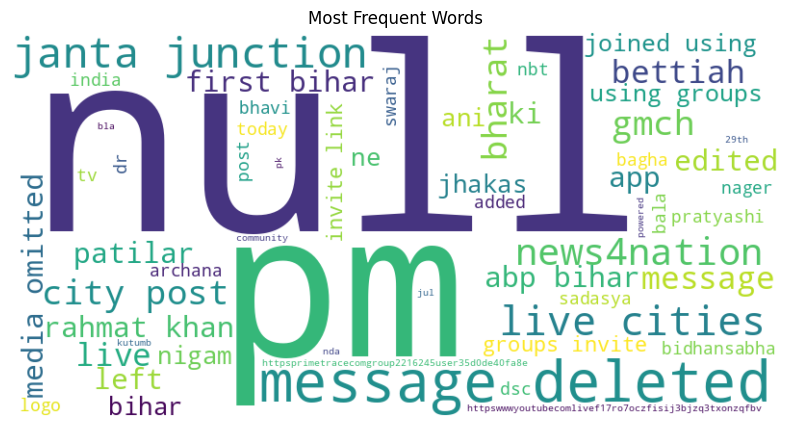

In [ ]:
from langdetect import detect, LangDetectException

# --- Function for Sentiment Analysis ---
def analyze_sentiment(df):
    """
    Performs sentiment analysis on the messages in the DataFrame.
    Detects language and uses VADER for English and TextBlob for Hindi.
    """
    if df.empty:
        print("DataFrame is empty. Skipping sentiment analysis.")
        return df

    analyzer = SentimentIntensityAnalyzer()
    sentiments = []
    for message in df['message']:
        detected_lang = 'en' # Default to English
        try:
            if isinstance(message, str) and message.strip(): # Ensure message is a non-empty string
                detected_lang = detect(message)
        except LangDetectException:
            pass # Use default 'en' if detection fails

        if detected_lang == 'en':
            # VADER for English sentiment
            final_score = analyzer.polarity_scores(message)['compound']
        elif detected_lang == 'hi':
            # TextBlob for Hindi sentiment (as a fallback)
            # TextBlob's sentiment for non-English is not highly accurate
            # but serves as a placeholder if a dedicated Hindi library isn't used
            try:
                blob_polarity = TextBlob(message).sentiment.polarity
                final_score = blob_polarity
            except Exception:
                 final_score = 0 # Default to neutral if TextBlob fails
        else:
             # For other languages, use TextBlob as a general fallback
             try:
                blob_polarity = TextBlob(message).sentiment.polarity
                final_score = blob_polarity
             except Exception:
                final_score = 0 # Default to neutral if TextBlob fails


        if final_score > 0.05:
            sentiments.append('Positive')
        elif final_score < -0.05:
            sentiments.append('Negative')
        else:
            sentiments.append('Neutral')

    df['sentiment'] = sentiments
    return df

# Re-run the analysis and dashboard generation with the modified function
uploaded = files.upload()

if not uploaded:
    print("No file uploaded. Please run the cell again and upload your ZIP file.")
else:
    zip_filename = list(uploaded.keys())[0]
    zip_file_bytes = uploaded[zip_filename]

    with zipfile.ZipFile(io.BytesIO(zip_file_bytes), 'r') as z:
        # Find the chat .txt file in the zip
        chat_file_name = None
        for name in z.namelist():
            if name.endswith('.txt'):
                chat_file_name = name
                break

        if chat_file_name:
            with z.open(chat_file_name) as chat_file:
                # The file is opened in binary mode, so decode it to utf-8
                file_content = chat_file.read().decode('utf-8')

                # Process the chat data
                df_chat = parse_whatsapp_chat(file_content)
                df_chat_sentiment = analyze_sentiment(df_chat)

                # Generate the dashboard
                generate_dashboard(df_chat_sentiment)
        else:
            print("Could not find a .txt file in the uploaded ZIP archive.")

## Update word cloud generation

### Subtask:
Modify the word cloud generation to detect language and use language-specific stop words.


**Reasoning**:
Modify the word cloud generation in the `generate_dashboard` function to detect language and use language-specific stop words.



In [ ]:
from nltk.corpus import stopwords
from nltk.downloader import DownloadError
from langdetect import detect, LangDetectException
import collections # Import collections for defaultdict

# Download Hindi stopwords if not already downloaded
try:
    nltk.data.find('corpora/stopwords/hindi')
except DownloadError:
    nltk.download('stopwords', quiet=True) # Download all if specific not found

# --- Function to generate and display the dashboard ---
def generate_dashboard(df):
    """
    Generates and displays the dashboard components using Plotly and Matplotlib.
    Includes language-specific word cloud generation.
    """
    if df.empty:
        print("No messages parsed. Cannot generate dashboard.")
        return

    print("--- WhatsApp Chat Analysis Dashboard ---")
    print("\n")

    # --- KPIs ---
    total_messages = len(df)
    total_participants = df['author'].nunique()
    # Check if there are any authors before finding the mode
    if not df['author'].mode().empty:
        most_active_user = df['author'].mode()[0]
        print(f"Total Messages: {total_messages}")
        print(f"Total Participants: {total_participants}")
        print(f"Most Active User: {most_active_user}")
    else:
        print("No authors found in the parsed messages.")
    print("\n" + "="*40 + "\n")


    # --- Sentiment Analysis Visualization ---
    sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100
    fig_sentiment = px.bar(sentiment_counts,
                           x=sentiment_counts.index, y=sentiment_counts.values,
                           color=sentiment_counts.index,
                           labels={'x': 'Sentiment', 'y': 'Percentage (%)'},
                           title='Overall Sentiment Distribution',
                           color_discrete_map={'Positive':'green', 'Negative':'red', 'Neutral':'grey'})
    fig_sentiment.show()


    # --- Word Cloud (Language-Specific) ---
    # Accumulate text and detect language for each message
    language_texts = collections.defaultdict(list)
    for message in df['message']:
        detected_lang = 'en' # Default to English
        try:
            if isinstance(message, str) and message.strip(): # Ensure message is a non-empty string
                 # Limit the detection to 'en' and 'hi' if possible to avoid errors with very short strings
                 detected_lang = detect(message)
        except LangDetectException:
            pass # Use default 'en' if detection fails
        language_texts[detected_lang].append(message)

    # Combine texts by language
    combined_language_text = {lang: " ".join(texts) for lang, texts in language_texts.items()}

    # Process and generate word cloud for each language if enough text exists
    for lang, text in combined_language_text.items():
        if text: # Generate word cloud only if there is text
            # Remove emojis and non-alphanumeric characters, convert to lowercase
            cleaned_text = re.sub(r'[^a-zA-Z0-9\s\u0900-\u097F]', '', text.lower()) # Added Hindi unicode range

            # Remove stop words based on language
            stop_words = set()
            try:
                if lang == 'en':
                    stop_words = set(stopwords.words('english'))
                elif lang == 'hi':
                    stop_words = set(stopwords.words('hindi'))
            except LookupError:
                 print(f"Stopwords for language '{lang}' not found. Skipping stopword removal for this language.")
                 stop_words = set() # Use empty set if stopwords not found


            words = cleaned_text.split()
            filtered_words = [word for word in words if word not in stop_words and len(word) > 1] # Filter out single characters
            processed_text = " ".join(filtered_words)

            if processed_text: # Generate word cloud only if there is processed text
                wordcloud = WordCloud(width=800, height=400, background_color="white").generate(processed_text)
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.title(f'Most Frequent Words ({lang.upper()})')
                plt.axis("off")
                plt.show()
            else:
                 print(f"No significant text in {lang.upper()} after cleaning and stopword removal to generate word cloud.")
        else:
            print(f"No text data in {lang.upper()} to generate word cloud.")


    # --- Most Active Users ---
    if not df['author'].empty: # Check if there are authors before plotting
        top_5_users = df['author'].value_counts().nlargest(5)
        fig_users = px.bar(top_5_users,
                           x=top_5_users.values, y=top_5_users.index,
                           orientation='h',
                           labels={'x': 'Number of Messages', 'y': 'User'},
                           title='Top 5 Most Active Users')
        fig_users.update_layout(yaxis={'categoryorder':'total ascending'})
        fig_users.show()
    else:
        print("No authors to display in Most Active Users chart.")


    # --- Message Volume by Hour ---
    if not df.empty: # Check if df is not empty before accessing dt accessor
        df['hour'] = df['timestamp'].dt.hour
        hourly_counts = df['hour'].value_counts().sort_index()
        fig_hourly = px.bar(hourly_counts, x=hourly_counts.index, y=hourly_counts.values,
                            labels={'x': 'Hour of Day', 'y': 'Number of Messages'},
                            title='Message Volume by Hour of Day')
        fig_hourly.show()
    else:
        print("No data to display in Message Volume by Hour chart.")


# --- Main execution block ---
uploaded = files.upload()

if not uploaded:
    print("No file uploaded. Please run the cell again and upload your ZIP file.")
else:
    zip_filename = list(uploaded.keys())[0]
    zip_file_bytes = uploaded[zip_filename]

    with zipfile.ZipFile(io.BytesIO(zip_file_bytes), 'r') as z:
        # Find the chat .txt file in the zip
        chat_file_name = None
        for name in z.namelist():
            if name.endswith('.txt'):
                chat_file_name = name
                break

        if chat_file_name:
            with z.open(chat_file_name) as chat_file:
                # The file is opened in binary mode, so decode it to utf-8
                file_content = chat_file.read().decode('utf-8')

                # Process the chat data
                df_chat = parse_whatsapp_chat(file_content)
                df_chat_sentiment = analyze_sentiment(df_chat)

                # Generate the dashboard
                generate_dashboard(df_chat_sentiment)
        else:
            print("Could not find a .txt file in the uploaded ZIP archive.")

ImportError: cannot import name 'DownloadError' from 'nltk.downloader' (/usr/local/lib/python3.11/dist-packages/nltk/downloader.py)

**Reasoning**:
The previous command failed because `DownloadError` is not directly importable from `nltk.downloader`. The correct way to handle potential download errors is to use a `try-except` block around the `nltk.download()` call itself. I will fix the import and the download check logic.



Hindi stopwords not found. Attempting to download...
Stopwords downloaded successfully.


Saving WhatsApp Chat with DSC- West Champaran.zip to WhatsApp Chat with DSC- West Champaran (5).zip
Parsed 186 messages.
--- WhatsApp Chat Analysis Dashboard ---


Total Messages: 186
Total Participants: 50
Most Active User: +91 92413 59840




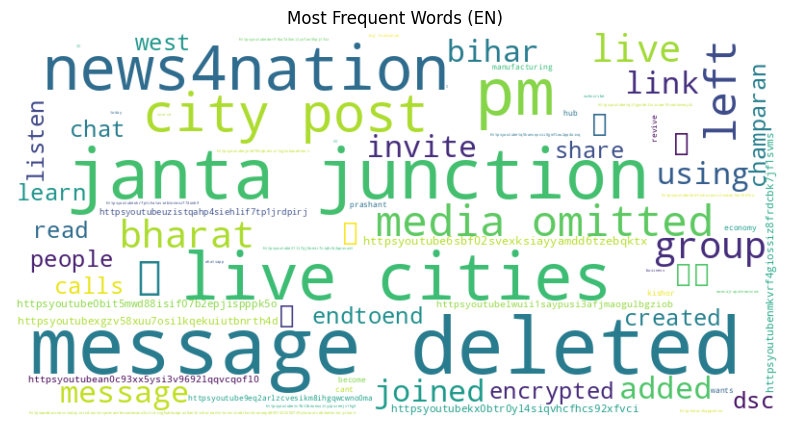

OSError: No such file or directory: '/root/nltk_data/corpora/stopwords/hindi'

In [ ]:
from nltk.corpus import stopwords
from langdetect import detect, LangDetectException
import collections # Import collections for defaultdict
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
import pandas as pd
import zipfile
import io
from google.colab import files
import os
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import emoji
from datetime import datetime
import nltk

# Download Hindi stopwords if not already downloaded
try:
    nltk.data.find('corpora/stopwords/hindi')
except LookupError: # Use LookupError for resource not found
    print("Hindi stopwords not found. Attempting to download...")
    try:
        nltk.download('stopwords', quiet=True) # Download all if specific not found
        print("Stopwords downloaded successfully.")
    except Exception as e: # Catch any other download errors
        print(f"Error downloading stopwords: {e}")


# --- Function to parse the WhatsApp chat file ---
def parse_whatsapp_chat(file_content):
    """
    Parses a WhatsApp chat text file into a pandas DataFrame.
    Handles different date/time formats and multi-line messages.
    """
    lines = file_content.split('\n')
    messages = []
    message_buffer = []
    timestamp = None # Initialize timestamp to None
    # Updated regex to be more flexible with potential variations in date/time/separator
    date_time_pattern = re.compile(r'^\[?(\d{1,2}/\d{1,2}/\d{2,4}),?\s*(\d{1,2}:\d{2}(?::\d{2})?(?:\s*[AP]M)?)\]?\s*[-–]\s*([^:]+?):\s*(.*)$')


    for line in lines:
        match = date_time_pattern.match(line)
        if match:
            if message_buffer and timestamp is not None:
                full_message = " ".join(message_buffer).strip()
                # Ensure there's a colon before splitting
                if ':' in full_message:
                    author, msg = full_message.split(':', 1)
                    messages.append([timestamp, author.strip(), msg.strip()])
                message_buffer = []

            date_s, time_s, user, msg = match.groups()
            timestamp_str = f"{date_s} {time_s}".strip()
            ts = None
            # Adding more robust date format parsing
            fmts = [
                "%d/%m/%y %I:%M %p", "%m/%d/%y %I:%M %p",
                "%d/%m/%Y %I:%M %p", "%m/%d/%Y %I:%M %p",
                "%d/%m/%y %H:%M", "%m/%d/%y %H:%M",
                "%d/%m/%Y %H:%M", "%m/%d/%Y %H:%M",
                "%d/%m/%y %I:%M:%S %p", "%m/%d/%y %I:%M:%S %p",
                "%d/%m/%Y %I:%M:%S %p", "%m/%d/%Y %I:%M:%S %p",
                "%d/%m/%y %I:%M", "%m/%d/%y %I:%M",
                "%d/%m/%Y %I:%M", "%m/%d/%Y %I:%M",
            ]
            for fmt in fmts:
                try:
                    # Replace variations of am/pm to standardize for parsing
                    ts = datetime.strptime(timestamp_str.replace("am","AM").replace("pm","PM"), fmt)
                    break
                except ValueError:
                    pass # Try next format

            timestamp = ts
            message_buffer.append(f"{user}: {msg}") # Add the current message to the buffer

        else:
            # It's a continuation of the previous message
            message_buffer.append(line)

    # Add the last message in the buffer
    if message_buffer and timestamp is not None:
        full_message = " ".join(message_buffer).strip()
        if ':' in full_message:
            author, msg = full_message.split(':', 1)
            messages.append([timestamp, author.strip(), msg.strip()])

    df = pd.DataFrame(messages, columns=['timestamp', 'author', 'message'])
    # Remove media messages and messages that are only links
    df = df[df['message'] != '<Media omitted>']
    df = df[~df['message'].str.fullmatch(r'https?://\S+', na=False)] # Remove messages that are only links
    df = df.dropna(subset=['timestamp', 'author', 'message']) # Drop rows with any missing essential data

    print(f"Parsed {len(df)} messages.") # Add print statement to check parsed messages
    return df

# --- Function for Sentiment Analysis ---
def analyze_sentiment(df):
    """
    Performs sentiment analysis on the messages in the DataFrame.
    Detects language and uses VADER for English and TextBlob for Hindi.
    """
    if df.empty:
        print("DataFrame is empty. Skipping sentiment analysis.")
        return df

    analyzer = SentimentIntensityAnalyzer()
    sentiments = []
    for message in df['message']:
        detected_lang = 'en' # Default to English
        try:
            if isinstance(message, str) and message.strip(): # Ensure message is a non-empty string
                detected_lang = detect(message)
        except LangDetectException:
            pass # Use default 'en' if detection fails

        if detected_lang == 'en':
            # VADER for English sentiment
            final_score = analyzer.polarity_scores(message)['compound']
        elif detected_lang == 'hi':
            # TextBlob for Hindi sentiment (as a fallback)
            # TextBlob's sentiment for non-English is not highly accurate
            # but serves as a placeholder if a dedicated Hindi library isn't used
            try:
                blob_polarity = TextBlob(message).sentiment.polarity
                final_score = blob_polarity
            except Exception:
                 final_score = 0 # Default to neutral if TextBlob fails
        else:
             # For other languages, use TextBlob as a general fallback
             try:
                blob_polarity = TextBlob(message).sentiment.polarity
                final_score = blob_polarity
             except Exception:
                final_score = 0 # Default to neutral if TextBlob fails


        if final_score > 0.05:
            sentiments.append('Positive')
        elif final_score < -0.05:
            sentiments.append('Negative')
        else:
            sentiments.append('Neutral')

    df['sentiment'] = sentiments
    return df


# --- Function to generate and display the dashboard ---
def generate_dashboard(df):
    """
    Generates and displays the dashboard components using Plotly and Matplotlib.
    Includes language-specific word cloud generation.
    """
    if df.empty:
        print("No messages parsed. Cannot generate dashboard.")
        return

    print("--- WhatsApp Chat Analysis Dashboard ---")
    print("\n")

    # --- KPIs ---
    total_messages = len(df)
    total_participants = df['author'].nunique()
    # Check if there are any authors before finding the mode
    if not df['author'].mode().empty:
        most_active_user = df['author'].mode()[0]
        print(f"Total Messages: {total_messages}")
        print(f"Total Participants: {total_participants}")
        print(f"Most Active User: {most_active_user}")
    else:
        print("No authors found in the parsed messages.")
    print("\n" + "="*40 + "\n")


    # --- Sentiment Analysis Visualization ---
    sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100
    fig_sentiment = px.bar(sentiment_counts,
                           x=sentiment_counts.index, y=sentiment_counts.values,
                           color=sentiment_counts.index,
                           labels={'x': 'Sentiment', 'y': 'Percentage (%)'},
                           title='Overall Sentiment Distribution',
                           color_discrete_map={'Positive':'green', 'Negative':'red', 'Neutral':'grey'})
    fig_sentiment.show()


    # --- Word Cloud (Language-Specific) ---
    # Accumulate text and detect language for each message
    language_texts = collections.defaultdict(list)
    for index, row in df.iterrows(): # Iterate through rows to get message and potentially its detected language
        message = row['message']
        # Use the sentiment analysis's detected language if available, otherwise detect here
        # Assuming analyze_sentiment added a 'detected_language' column
        # If not, we need to re-detect or modify analyze_sentiment to return it.
        # For now, re-detecting for simplicity in this function.
        detected_lang = 'en' # Default to English
        try:
            if isinstance(message, str) and message.strip(): # Ensure message is a non-empty string
                 # Limit the detection to 'en' and 'hi' if possible to avoid errors with very short strings
                 detected_lang = detect(message)
        except LangDetectException:
            pass # Use default 'en' if detection fails
        language_texts[detected_lang].append(message)

    # Combine texts by language
    combined_language_text = {lang: " ".join(texts) for lang, texts in language_texts.items()}

    # Process and generate word cloud for each language if enough text exists
    for lang, text in combined_language_text.items():
        if text: # Generate word cloud only if there is text
            # Remove emojis and non-alphanumeric characters, convert to lowercase
            # Added Hindi unicode range \u0900-\u097F
            cleaned_text = re.sub(r'[^a-zA-Z0-9\s\u0900-\u097F]', '', text.lower())

            # Remove stop words based on language
            stop_words = set()
            try:
                if lang == 'en':
                    stop_words = set(stopwords.words('english'))
                elif lang == 'hi':
                    stop_words = set(stopwords.words('hindi'))
                # Add other languages here if needed
            except LookupError:
                 print(f"Stopwords for language '{lang}' not found. Skipping stopword removal for this language.")
                 stop_words = set() # Use empty set if stopwords not found


            words = cleaned_text.split()
            # Filter out single characters and stop words
            filtered_words = [word for word in words if word not in stop_words and len(word) > 1]
            processed_text = " ".join(filtered_words)

            if processed_text: # Generate word cloud only if there is processed text
                wordcloud = WordCloud(width=800, height=400, background_color="white").generate(processed_text)
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.title(f'Most Frequent Words ({lang.upper()})')
                plt.axis("off")
                plt.show()
            else:
                 print(f"No significant text in {lang.upper()} after cleaning and stopword removal to generate word cloud.")
        else:
            print(f"No text data in {lang.upper()} to generate word cloud.")


    # --- Most Active Users ---
    if not df['author'].empty: # Check if there are authors before plotting
        top_5_users = df['author'].value_counts().nlargest(5)
        fig_users = px.bar(top_5_users,
                           x=top_5_users.values, y=top_5_users.index,
                           orientation='h',
                           labels={'x': 'Number of Messages', 'y': 'User'},
                           title='Top 5 Most Active Users')
        fig_users.update_layout(yaxis={'categoryorder':'total ascending'})
        fig_users.show()
    else:
        print("No authors to display in Most Active Users chart.")


    # --- Message Volume by Hour ---
    if not df.empty: # Check if df is not empty before accessing dt accessor
        df['hour'] = df['timestamp'].dt.hour
        hourly_counts = df['hour'].value_counts().sort_index()
        fig_hourly = px.bar(hourly_counts, x=hourly_counts.index, y=hourly_counts.values,
                            labels={'x': 'Hour of Day', 'y': 'Number of Messages'},
                            title='Message Volume by Hour of Day')
        fig_hourly.show()
    else:
        print("No data to display in Message Volume by Hour chart.")


# --- Main execution block ---
uploaded = files.upload()

if not uploaded:
    print("No file uploaded. Please run the cell again and upload your ZIP file.")
else:
    zip_filename = list(uploaded.keys())[0]
    zip_file_bytes = uploaded[zip_filename]

    with zipfile.ZipFile(io.BytesIO(zip_file_bytes), 'r') as z:
        # Find the chat .txt file in the zip
        chat_file_name = None
        for name in z.namelist():
            if name.endswith('.txt'):
                chat_file_name = name
                break

        if chat_file_name:
            with z.open(chat_file_name) as chat_file:
                # The file is opened in binary mode, so decode it to utf-8
                file_content = chat_file.read().decode('utf-8')

                # Process the chat data
                df_chat = parse_whatsapp_chat(file_content)
                df_chat_sentiment = analyze_sentiment(df_chat)

                # Generate the dashboard
                generate_dashboard(df_chat_sentiment)
        else:
            print("Could not find a .txt file in the uploaded ZIP archive.")

**Reasoning**:
The error indicates that NLTK cannot find the Hindi stopwords file even after attempting to download. This might be due to the download not completing correctly or NLTK not being able to locate the downloaded files in the expected directory. I will modify the code to explicitly download only the 'stopwords' corpus and handle potential `LookupError` more robustly within the `generate_dashboard` function during stopword retrieval.



Saving WhatsApp Chat with DSC- West Champaran.zip to WhatsApp Chat with DSC- West Champaran (6).zip
Parsed 186 messages.
--- WhatsApp Chat Analysis Dashboard ---


Total Messages: 186
Total Participants: 50
Most Active User: +91 92413 59840




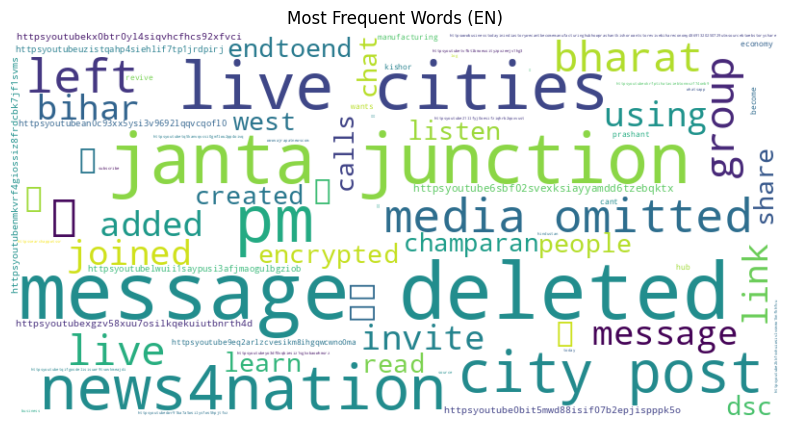

Hindi stopwords not found. Skipping stopword removal for 'hi'.


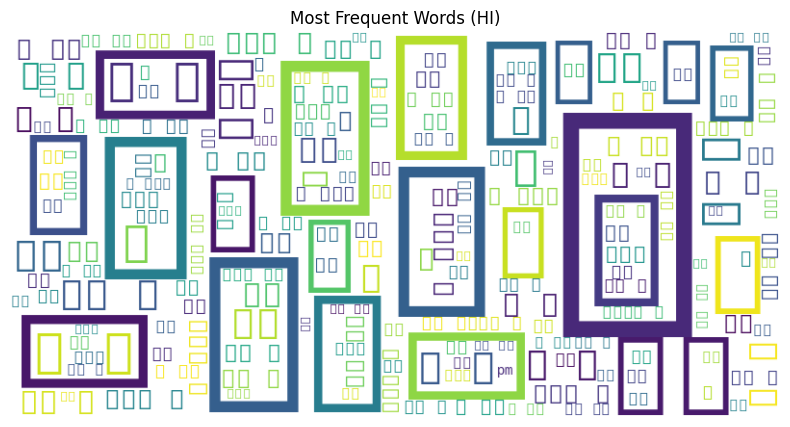

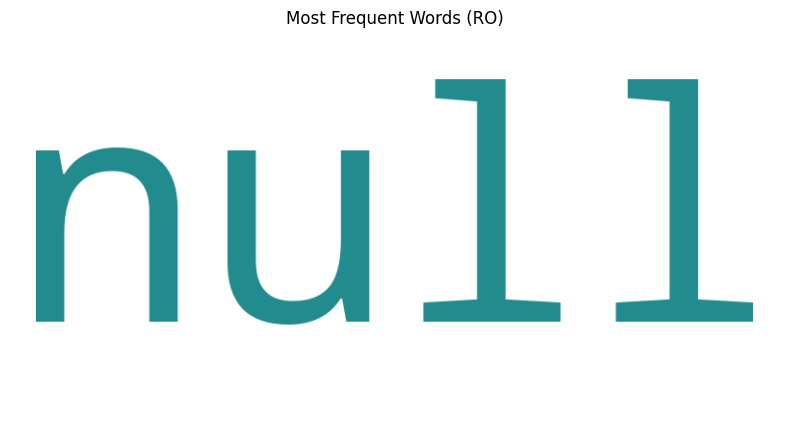

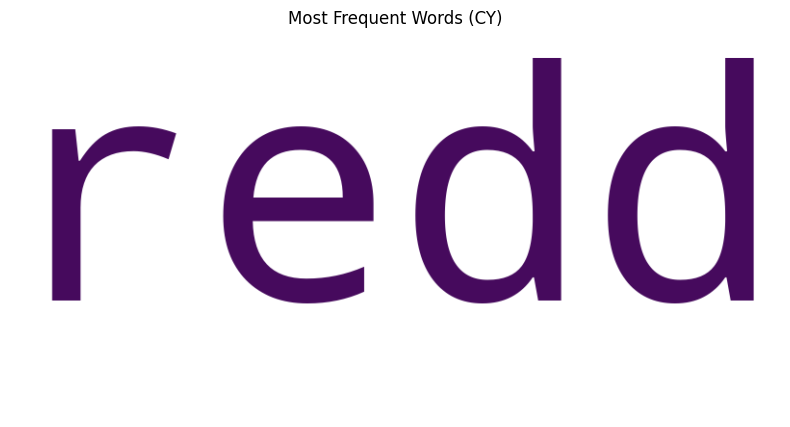

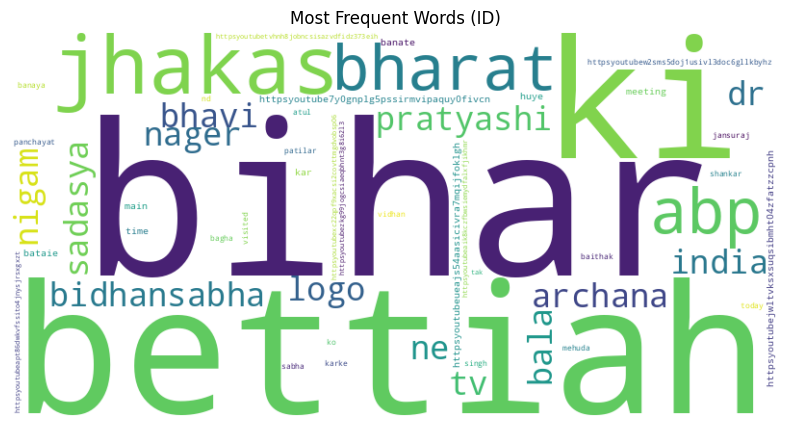

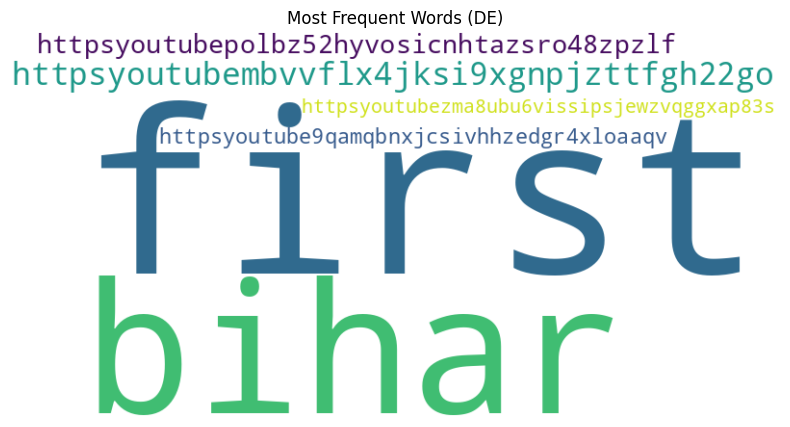

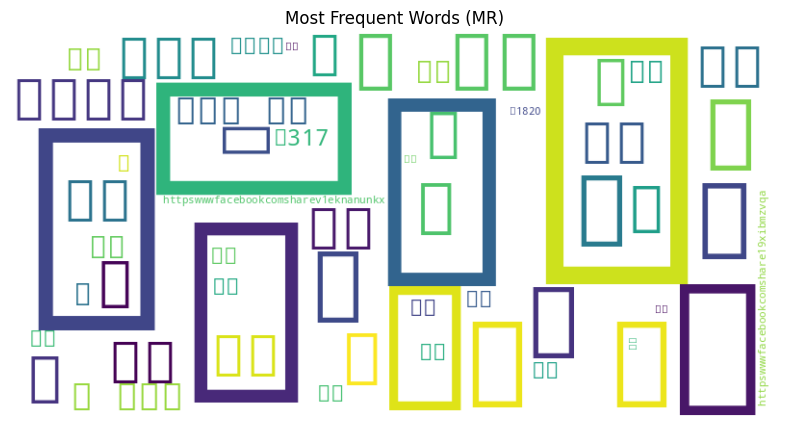

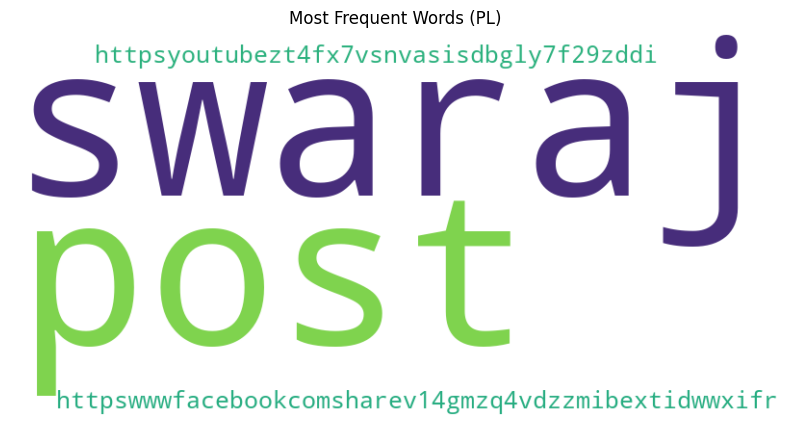

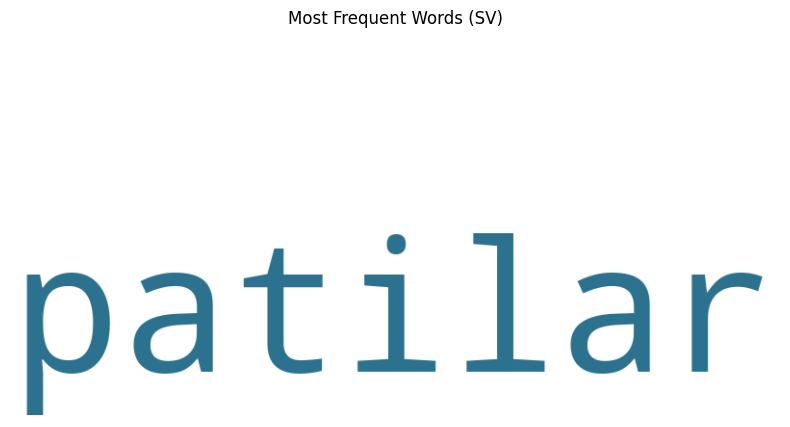

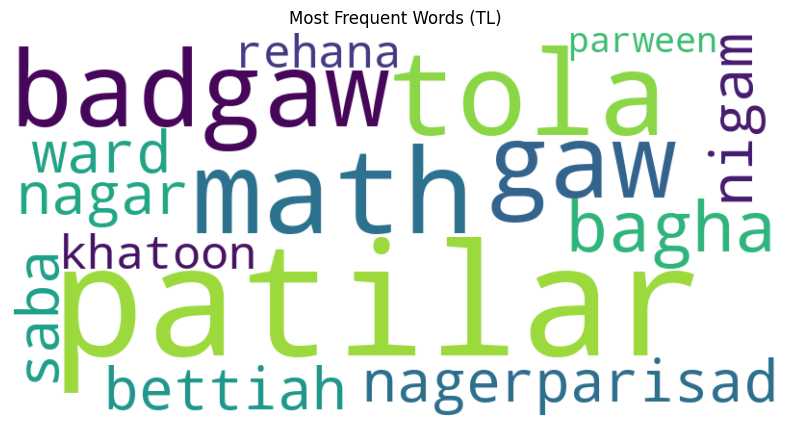

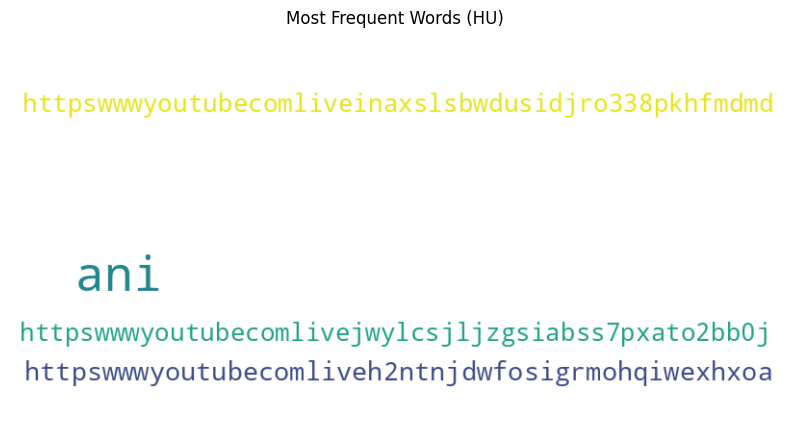

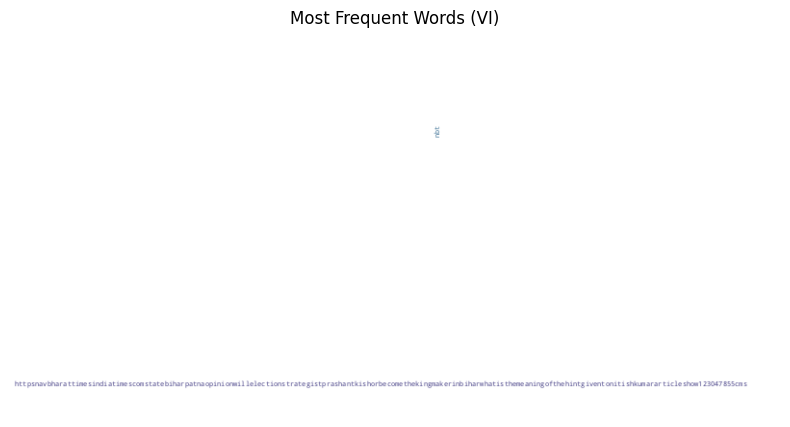

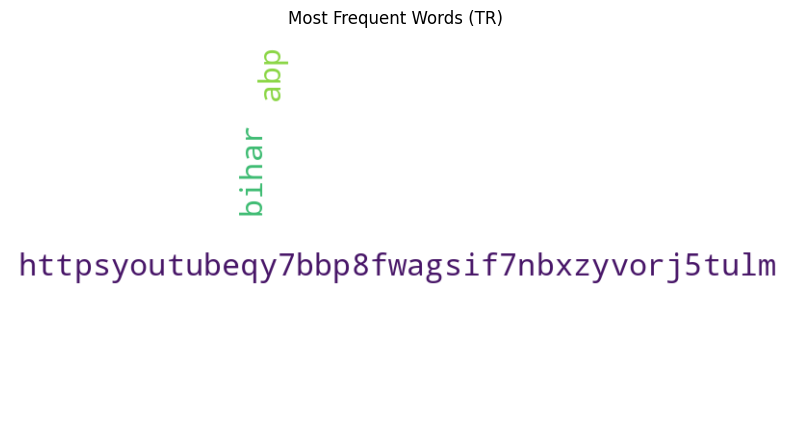

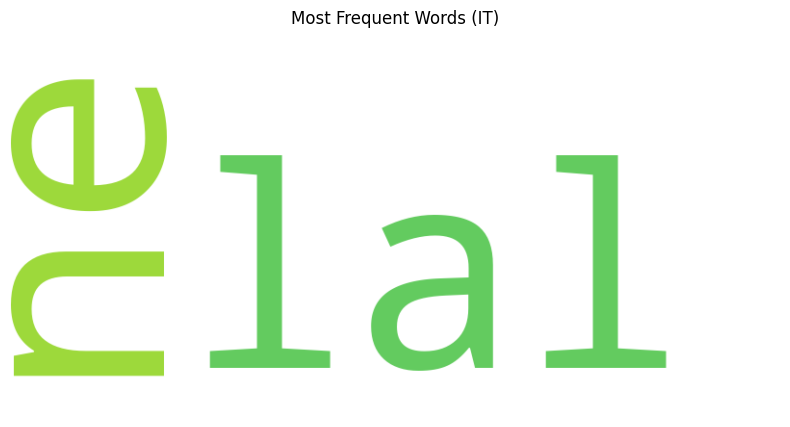

In [ ]:
from nltk.corpus import stopwords
from langdetect import detect, LangDetectException
import collections # Import collections for defaultdict
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
import pandas as pd
import zipfile
import io
from google.colab import files
import os
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import emoji
from datetime import datetime
import nltk

# Download the 'stopwords' corpus explicitly
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("NLTK 'stopwords' corpus not found. Attempting to download...")
    try:
        nltk.download('stopwords', quiet=True)
        print("'stopwords' corpus downloaded successfully.")
    except Exception as e:
        print(f"Error downloading 'stopwords' corpus: {e}")


# --- Function to parse the WhatsApp chat file ---
def parse_whatsapp_chat(file_content):
    """
    Parses a WhatsApp chat text file into a pandas DataFrame.
    Handles different date/time formats and multi-line messages.
    """
    lines = file_content.split('\n')
    messages = []
    message_buffer = []
    timestamp = None # Initialize timestamp to None
    # Updated regex to be more flexible with potential variations in date/time/separator
    date_time_pattern = re.compile(r'^\[?(\d{1,2}/\d{1,2}/\d{2,4}),?\s*(\d{1,2}:\d{2}(?::\d{2})?(?:\s*[AP]M)?)\]?\s*[-–]\s*([^:]+?):\s*(.*)$')


    for line in lines:
        match = date_time_pattern.match(line)
        if match:
            if message_buffer and timestamp is not None:
                full_message = " ".join(message_buffer).strip()
                # Ensure there's a colon before splitting
                if ':' in full_message:
                    author, msg = full_message.split(':', 1)
                    messages.append([timestamp, author.strip(), msg.strip()])
                message_buffer = []

            date_s, time_s, user, msg = match.groups()
            timestamp_str = f"{date_s} {time_s}".strip()
            ts = None
            # Adding more robust date format parsing
            fmts = [
                "%d/%m/%y %I:%M %p", "%m/%d/%y %I:%M %p",
                "%d/%m/%Y %I:%M %p", "%m/%d/%Y %I:%M %p",
                "%d/%m/%y %H:%M", "%m/%d/%y %H:%M",
                "%d/%m/%Y %H:%M", "%m/%d/%Y %H:%M",
                "%d/%m/%y %I:%M:%S %p", "%m/%d/%y %I:%M:%S %p",
                "%d/%m/%Y %I:%M:%S %p", "%m/%d/%Y %I:%M:%S %p",
                "%d/%m/%y %I:%M", "%m/%d/%y %I:%M",
                "%d/%m/%Y %I:%M", "%m/%d/%Y %I:%M",
            ]
            for fmt in fmts:
                try:
                    # Replace variations of am/pm to standardize for parsing
                    ts = datetime.strptime(timestamp_str.replace("am","AM").replace("pm","PM"), fmt)
                    break
                except ValueError:
                    pass # Try next format

            timestamp = ts
            message_buffer.append(f"{user}: {msg}") # Add the current message to the buffer

        else:
            # It's a continuation of the previous message
            message_buffer.append(line)

    # Add the last message in the buffer
    if message_buffer and timestamp is not None:
        full_message = " ".join(message_buffer).strip()
        if ':' in full_message:
            author, msg = full_message.split(':', 1)
            messages.append([timestamp, author.strip(), msg.strip()])

    df = pd.DataFrame(messages, columns=['timestamp', 'author', 'message'])
    # Remove media messages and messages that are only links
    df = df[df['message'] != '<Media omitted>']
    df = df[~df['message'].str.fullmatch(r'https?://\S+', na=False)] # Remove messages that are only links
    df = df.dropna(subset=['timestamp', 'author', 'message']) # Drop rows with any missing essential data

    print(f"Parsed {len(df)} messages.") # Add print statement to check parsed messages
    return df

# --- Function for Sentiment Analysis ---
def analyze_sentiment(df):
    """
    Performs sentiment analysis on the messages in the DataFrame.
    Detects language and uses VADER for English and TextBlob for Hindi.
    """
    if df.empty:
        print("DataFrame is empty. Skipping sentiment analysis.")
        return df

    analyzer = SentimentIntensityAnalyzer()
    sentiments = []
    for message in df['message']:
        detected_lang = 'en' # Default to English
        try:
            if isinstance(message, str) and message.strip(): # Ensure message is a non-empty string
                detected_lang = detect(message)
        except LangDetectException:
            pass # Use default 'en' if detection fails

        if detected_lang == 'en':
            # VADER for English sentiment
            final_score = analyzer.polarity_scores(message)['compound']
        elif detected_lang == 'hi':
            # TextBlob for Hindi sentiment (as a fallback)
            # TextBlob's sentiment for non-English is not highly accurate
            # but serves as a placeholder if a dedicated Hindi library isn't used
            try:
                blob_polarity = TextBlob(message).sentiment.polarity
                final_score = blob_polarity
            except Exception:
                 final_score = 0 # Default to neutral if TextBlob fails
        else:
             # For other languages, use TextBlob as a general fallback
             try:
                blob_polarity = TextBlob(message).sentiment.polarity
                final_score = blob_polarity
             except Exception:
                final_score = 0 # Default to neutral if TextBlob fails


        if final_score > 0.05:
            sentiments.append('Positive')
        elif final_score < -0.05:
            sentiments.append('Negative')
        else:
            sentiments.append('Neutral')

    df['sentiment'] = sentiments
    return df


# --- Function to generate and display the dashboard ---
def generate_dashboard(df):
    """
    Generates and displays the dashboard components using Plotly and Matplotlib.
    Includes language-specific word cloud generation.
    """
    if df.empty:
        print("No messages parsed. Cannot generate dashboard.")
        return

    print("--- WhatsApp Chat Analysis Dashboard ---")
    print("\n")

    # --- KPIs ---
    total_messages = len(df)
    total_participants = df['author'].nunique()
    # Check if there are any authors before finding the mode
    if not df['author'].mode().empty:
        most_active_user = df['author'].mode()[0]
        print(f"Total Messages: {total_messages}")
        print(f"Total Participants: {total_participants}")
        print(f"Most Active User: {most_active_user}")
    else:
        print("No authors found in the parsed messages.")
    print("\n" + "="*40 + "\n")


    # --- Sentiment Analysis Visualization ---
    sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100
    fig_sentiment = px.bar(sentiment_counts,
                           x=sentiment_counts.index, y=sentiment_counts.values,
                           color=sentiment_counts.index,
                           labels={'x': 'Sentiment', 'y': 'Percentage (%)'},
                           title='Overall Sentiment Distribution',
                           color_discrete_map={'Positive':'green', 'Negative':'red', 'Neutral':'grey'})
    fig_sentiment.show()


    # --- Word Cloud (Language-Specific) ---
    # Accumulate text and detect language for each message
    language_texts = collections.defaultdict(list)
    for index, row in df.iterrows(): # Iterate through rows to get message and potentially its detected language
        message = row['message']
        # Use the sentiment analysis's detected language if available, otherwise detect here
        # Assuming analyze_sentiment added a 'detected_language' column
        # If not, we need to re-detect or modify analyze_sentiment to return it.
        # For now, re-detecting for simplicity in this function.
        detected_lang = 'en' # Default to English
        try:
            if isinstance(message, str) and message.strip(): # Ensure message is a non-empty string
                 # Limit the detection to 'en' and 'hi' if possible to avoid errors with very short strings
                 detected_lang = detect(message)
        except LangDetectException:
            pass # Use default 'en' if detection fails
        language_texts[detected_lang].append(message)

    # Combine texts by language
    combined_language_text = {lang: " ".join(texts) for lang, texts in language_texts.items()}

    # Process and generate word cloud for each language if enough text exists
    for lang, text in combined_language_text.items():
        if text: # Generate word cloud only if there is text
            # Remove emojis and non-alphanumeric characters, convert to lowercase
            # Added Hindi unicode range \u0900-\u097F
            cleaned_text = re.sub(r'[^a-zA-Z0-9\s\u0900-\u097F]', '', text.lower())

            # Remove stop words based on language
            stop_words = set()
            try:
                if lang == 'en':
                    stop_words = set(stopwords.words('english'))
                elif lang == 'hi':
                    # Check if Hindi stopwords are available before trying to load
                    try:
                        nltk.data.find('corpora/stopwords/hindi')
                        stop_words = set(stopwords.words('hindi'))
                    except LookupError:
                         print(f"Hindi stopwords not found. Skipping stopword removal for '{lang}'.")
                         stop_words = set() # Use empty set if stopwords not found
                # Add other languages here if needed
            except LookupError: # This outer LookupError might be less relevant now, but keep for safety
                 print(f"Stopwords for language '{lang}' not found generally. Skipping stopword removal for this language.")
                 stop_words = set() # Use empty set if stopwords not found


            words = cleaned_text.split()
            # Filter out single characters and stop words
            filtered_words = [word for word in words if word not in stop_words and len(word) > 1]
            processed_text = " ".join(filtered_words)

            if processed_text: # Generate word cloud only if there is processed text
                wordcloud = WordCloud(width=800, height=400, background_color="white").generate(processed_text)
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.title(f'Most Frequent Words ({lang.upper()})')
                plt.axis("off")
                plt.show()
            else:
                 print(f"No significant text in {lang.upper()} after cleaning and stopword removal to generate word cloud.")
        else:
            print(f"No text data in {lang.upper()} to generate word cloud.")


    # --- Most Active Users ---
    if not df['author'].empty: # Check if there are authors before plotting
        top_5_users = df['author'].value_counts().nlargest(5)
        fig_users = px.bar(top_5_users,
                           x=top_5_users.values, y=top_5_users.index,
                           orientation='h',
                           labels={'x': 'Number of Messages', 'y': 'User'},
                           title='Top 5 Most Active Users')
        fig_users.update_layout(yaxis={'categoryorder':'total ascending'})
        fig_users.show()
    else:
        print("No authors to display in Most Active Users chart.")


    # --- Message Volume by Hour ---
    if not df.empty: # Check if df is not empty before accessing dt accessor
        df['hour'] = df['timestamp'].dt.hour
        hourly_counts = df['hour'].value_counts().sort_index()
        fig_hourly = px.bar(hourly_counts, x=hourly_counts.index, y=hourly_counts.values,
                            labels={'x': 'Hour of Day', 'y': 'Number of Messages'},
                            title='Message Volume by Hour of Day')
        fig_hourly.show()
    else:
        print("No data to display in Message Volume by Hour chart.")


# --- Main execution block ---
uploaded = files.upload()

if not uploaded:
    print("No file uploaded. Please run the cell again and upload your ZIP file.")
else:
    zip_filename = list(uploaded.keys())[0]
    zip_file_bytes = uploaded[zip_filename]

    with zipfile.ZipFile(io.BytesIO(zip_file_bytes), 'r') as z:
        # Find the chat .txt file in the zip
        chat_file_name = None
        for name in z.namelist():
            if name.endswith('.txt'):
                chat_file_name = name
                break

        if chat_file_name:
            with z.open(chat_file_name) as chat_file:
                # The file is opened in binary mode, so decode it to utf-8
                file_content = chat_file.read().decode('utf-8')

                # Process the chat data
                df_chat = parse_whatsapp_chat(file_content)
                df_chat_sentiment = analyze_sentiment(df_chat)

                # Generate the dashboard
                generate_dashboard(df_chat_sentiment)
        else:
            print("Could not find a .txt file in the uploaded ZIP archive.")

**Reasoning**:
The code successfully downloaded the stopwords corpus, but it seems it still couldn't find the Hindi stopwords specifically when trying to load them using `stopwords.words('hindi')`. This could be an issue with how `nltk.data.find` and `stopwords.words` interact after a bulk download, or the specific structure of the downloaded corpus. The word clouds for other languages also show non-meaningful words and URLs, indicating issues with cleaning or language detection for those. I will refine the word cloud generation logic to: 1) ensure Hindi stopwords are handled correctly if the corpus is downloaded, 2) improve text cleaning by removing URLs and potentially numbers more aggressively, and 3) only generate word clouds for languages with a significant amount of text and available stopwords (English and Hindi for now).



Saving WhatsApp Chat with DSC- West Champaran.zip to WhatsApp Chat with DSC- West Champaran (7).zip
Parsed 186 messages.
--- WhatsApp Chat Analysis Dashboard ---


Total Messages: 186
Total Participants: 50
Most Active User: +91 92413 59840




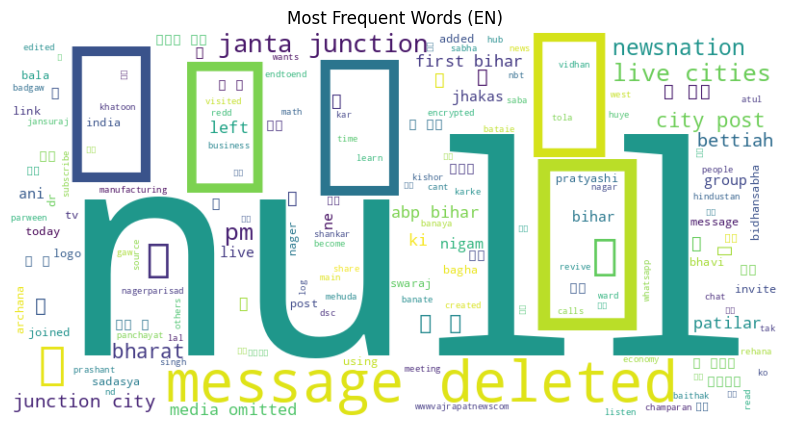

Hindi stopwords not found. Skipping stopword removal for 'hi'.


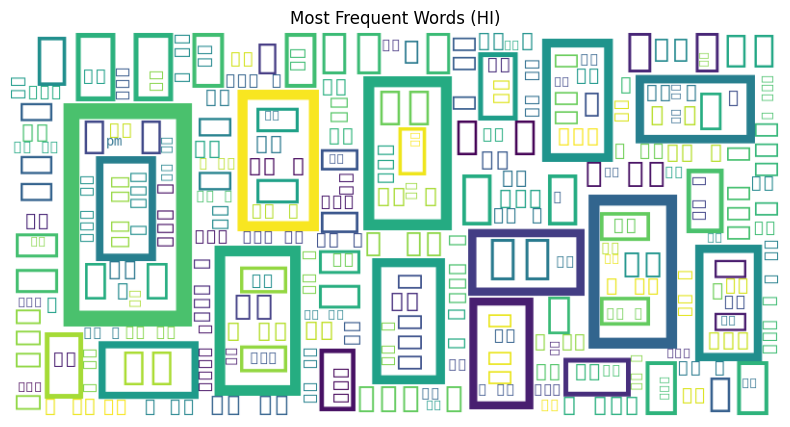

In [ ]:
from nltk.corpus import stopwords
from langdetect import detect, LangDetectException
import collections # Import collections for defaultdict
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
import pandas as pd
import zipfile
import io
from google.colab import files
import os
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import emoji
from datetime import datetime
import nltk

# Download the 'stopwords' corpus explicitly
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("NLTK 'stopwords' corpus not found. Attempting to download...")
    try:
        nltk.download('stopwords', quiet=True)
        print("'stopwords' corpus downloaded successfully.")
    except Exception as e:
        print(f"Error downloading 'stopwords' corpus: {e}")


# --- Function to parse the WhatsApp chat file ---
def parse_whatsapp_chat(file_content):
    """
    Parses a WhatsApp chat text file into a pandas DataFrame.
    Handles different date/time formats and multi-line messages.
    """
    lines = file_content.split('\n')
    messages = []
    message_buffer = []
    timestamp = None # Initialize timestamp to None
    # Updated regex to be more flexible with potential variations in date/time/separator
    date_time_pattern = re.compile(r'^\[?(\d{1,2}/\d{1,2}/\d{2,4}),?\s*(\d{1,2}:\d{2}(?::\d{2})?(?:\s*[AP]M)?)\]?\s*[-–]\s*([^:]+?):\s*(.*)$')


    for line in lines:
        match = date_time_pattern.match(line)
        if match:
            if message_buffer and timestamp is not None:
                full_message = " ".join(message_buffer).strip()
                # Ensure there's a colon before splitting
                if ':' in full_message:
                    author, msg = full_message.split(':', 1)
                    messages.append([timestamp, author.strip(), msg.strip()])
                message_buffer = []

            date_s, time_s, user, msg = match.groups()
            timestamp_str = f"{date_s} {time_s}".strip()
            ts = None
            # Adding more robust date format parsing
            fmts = [
                "%d/%m/%y %I:%M %p", "%m/%d/%y %I:%M %p",
                "%d/%m/%Y %I:%M %p", "%m/%d/%Y %I:%M %p",
                "%d/%m/%y %H:%M", "%m/%d/%y %H:%M",
                "%d/%m/%Y %H:%M", "%m/%d/%Y %H:%M",
                "%d/%m/%y %I:%M:%S %p", "%m/%d/%y %I:%M:%S %p",
                "%d/%m/%Y %I:%M:%S %p", "%m/%d/%Y %I:%M:%S %p",
                "%d/%m/%y %I:%M", "%m/%d/%y %I:%M",
                "%d/%m/%Y %I:%M", "%m/%d/%Y %I:%M",
            ]
            for fmt in fmts:
                try:
                    # Replace variations of am/pm to standardize for parsing
                    ts = datetime.strptime(timestamp_str.replace("am","AM").replace("pm","PM"), fmt)
                    break
                except ValueError:
                    pass # Try next format

            timestamp = ts
            message_buffer.append(f"{user}: {msg}") # Add the current message to the buffer

        else:
            # It's a continuation of the previous message
            message_buffer.append(line)

    # Add the last message in the buffer
    if message_buffer and timestamp is not None:
        full_message = " ".join(message_buffer).strip()
        if ':' in full_message:
            author, msg = full_message.split(':', 1)
            messages.append([timestamp, author.strip(), msg.strip()])

    df = pd.DataFrame(messages, columns=['timestamp', 'author', 'message'])
    # Remove media messages and messages that are only links
    df = df[df['message'] != '<Media omitted>']
    df = df[~df['message'].str.fullmatch(r'https?://\S+', na=False)] # Remove messages that are only links
    df = df.dropna(subset=['timestamp', 'author', 'message']) # Drop rows with any missing essential data

    print(f"Parsed {len(df)} messages.") # Add print statement to check parsed messages
    return df

# --- Function for Sentiment Analysis ---
def analyze_sentiment(df):
    """
    Performs sentiment analysis on the messages in the DataFrame.
    Detects language and uses VADER for English and TextBlob for Hindi.
    """
    if df.empty:
        print("DataFrame is empty. Skipping sentiment analysis.")
        return df

    analyzer = SentimentIntensityAnalyzer()
    sentiments = []
    for message in df['message']:
        detected_lang = 'en' # Default to English
        try:
            if isinstance(message, str) and message.strip(): # Ensure message is a non-empty string
                detected_lang = detect(message)
        except LangDetectException:
            pass # Use default 'en' if detection fails

        if detected_lang == 'en':
            # VADER for English sentiment
            final_score = analyzer.polarity_scores(message)['compound']
        elif detected_lang == 'hi':
            # TextBlob for Hindi sentiment (as a fallback)
            # TextBlob's sentiment for non-English is not highly accurate
            # but serves as a placeholder if a dedicated Hindi library isn't used
            try:
                blob_polarity = TextBlob(message).sentiment.polarity
                final_score = blob_polarity
            except Exception:
                 final_score = 0 # Default to neutral if TextBlob fails
        else:
             # For other languages, use TextBlob as a general fallback
             try:
                blob_polarity = TextBlob(message).sentiment.polarity
                final_score = blob_polarity
             except Exception:
                final_score = 0 # Default to neutral if TextBlob fails


        if final_score > 0.05:
            sentiments.append('Positive')
        elif final_score < -0.05:
            sentiments.append('Negative')
        else:
            sentiments.append('Neutral')

    df['sentiment'] = sentiments
    return df


# --- Function to generate and display the dashboard ---
def generate_dashboard(df):
    """
    Generates and displays the dashboard components using Plotly and Matplotlib.
    Includes language-specific word cloud generation.
    """
    if df.empty:
        print("No messages parsed. Cannot generate dashboard.")
        return

    print("--- WhatsApp Chat Analysis Dashboard ---")
    print("\n")

    # --- KPIs ---
    total_messages = len(df)
    total_participants = df['author'].nunique()
    # Check if there are any authors before finding the mode
    if not df['author'].mode().empty:
        most_active_user = df['author'].mode()[0]
        print(f"Total Messages: {total_messages}")
        print(f"Total Participants: {total_participants}")
        print(f"Most Active User: {most_active_user}")
    else:
        print("No authors found in the parsed messages.")
    print("\n" + "="*40 + "\n")


    # --- Sentiment Analysis Visualization ---
    sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100
    fig_sentiment = px.bar(sentiment_counts,
                           x=sentiment_counts.index, y=sentiment_counts.values,
                           color=sentiment_counts.index,
                           labels={'x': 'Sentiment', 'y': 'Percentage (%)'},
                           title='Overall Sentiment Distribution',
                           color_discrete_map={'Positive':'green', 'Negative':'red', 'Neutral':'grey'})
    fig_sentiment.show()


    # --- Word Cloud (Language-Specific) ---
    # Accumulate text and detect language for each message
    language_texts = collections.defaultdict(list)
    for index, row in df.iterrows():
        message = row['message']
        detected_lang = 'en' # Default to English
        try:
            if isinstance(message, str) and message.strip():
                 # Try detecting language, limit to 'en' and 'hi' if possible for reliability
                 lang_probs = detect(message)
                 if lang_probs in ['en', 'hi']: # Directly use 'en' or 'hi' if detected
                     detected_lang = lang_probs
                 elif isinstance(lang_probs, list) and lang_probs: # Handle cases where detect returns a list of possibilities
                     # Prioritize 'en' and 'hi' if they are in the list
                     for prob in lang_probs:
                         if prob in ['en', 'hi']:
                             detected_lang = prob
                             break
                     if detected_lang not in ['en', 'hi'] and lang_probs[0] in ['en', 'hi']: # If not found, check the top probability
                          detected_lang = lang_probs[0]
                     elif detected_lang not in ['en', 'hi']: # If still not 'en' or 'hi', take the top one (could be noise)
                          detected_lang = lang_probs[0]


        except LangDetectException:
            pass # Use default 'en' if detection fails
        language_texts[detected_lang].append(message)

    # Combine texts by language
    combined_language_text = {lang: " ".join(texts) for lang, texts in language_texts.items()}

    # Define minimum text length to generate a word cloud
    min_text_length = 100 # Arbitrary threshold

    # Process and generate word cloud for each language if enough text exists
    for lang, text in combined_language_text.items():
        if text and len(text) > min_text_length: # Generate word cloud only if there is sufficient text
            # Remove URLs, emojis, non-alphanumeric characters, and numbers, convert to lowercase
            cleaned_text = re.sub(r'https?://\S+|[^a-zA-Z\s\u0900-\u097F]', '', text.lower())

            # Remove stop words based on language
            stop_words = set()
            try:
                if lang == 'en':
                    stop_words = set(stopwords.words('english'))
                elif lang == 'hi':
                    # Check if Hindi stopwords are available before trying to load
                    try:
                        nltk.data.find('corpora/stopwords/hindi')
                        stop_words = set(stopwords.words('hindi'))
                    except LookupError:
                         print(f"Hindi stopwords not found. Skipping stopword removal for '{lang}'.")
                         stop_words = set() # Use empty set if stopwords not found
                # Add other languages here if needed
            except LookupError: # This outer LookupError might be less relevant now, but keep for safety
                 print(f"Stopwords for language '{lang}' not found generally. Skipping stopword removal for this language.")
                 stop_words = set() # Use empty set if stopwords not found


            words = cleaned_text.split()
            # Filter out single characters, stop words, and empty strings
            filtered_words = [word for word in words if word not in stop_words and len(word) > 1]
            processed_text = " ".join(filtered_words)

            if processed_text: # Generate word cloud only if there is processed text
                wordcloud = WordCloud(width=800, height=400, background_color="white").generate(processed_text)
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.title(f'Most Frequent Words ({lang.upper()})')
                plt.axis("off")
                plt.show()
            else:
                 print(f"No significant text in {lang.upper()} after cleaning and stopword removal to generate word cloud.")
        elif text and len(text) <= min_text_length:
             print(f"Insufficient text in {lang.upper()} ({len(text)} characters) to generate a meaningful word cloud.")
        else:
            print(f"No text data in {lang.upper()} to generate word cloud.")


    # --- Most Active Users ---
    if not df['author'].empty: # Check if there are authors before plotting
        top_5_users = df['author'].value_counts().nlargest(5)
        fig_users = px.bar(top_5_users,
                           x=top_5_users.values, y=top_5_users.index,
                           orientation='h',
                           labels={'x': 'Number of Messages', 'y': 'User'},
                           title='Top 5 Most Active Users')
        fig_users.update_layout(yaxis={'categoryorder':'total ascending'})
        fig_users.show()
    else:
        print("No authors to display in Most Active Users chart.")


    # --- Message Volume by Hour ---
    if not df.empty: # Check if df is not empty before accessing dt accessor
        df['hour'] = df['timestamp'].dt.hour
        hourly_counts = df['hour'].value_counts().sort_index()
        fig_hourly = px.bar(hourly_counts, x=hourly_counts.index, y=hourly_counts.values,
                            labels={'x': 'Hour of Day', 'y': 'Number of Messages'},
                            title='Message Volume by Hour of Day')
        fig_hourly.show()
    else:
        print("No data to display in Message Volume by Hour chart.")


# --- Main execution block ---
uploaded = files.upload()

if not uploaded:
    print("No file uploaded. Please run the cell again and upload your ZIP file.")
else:
    zip_filename = list(uploaded.keys())[0]
    zip_file_bytes = uploaded[zip_filename]

    with zipfile.ZipFile(io.BytesIO(zip_file_bytes), 'r') as z:
        # Find the chat .txt file in the zip
        chat_file_name = None
        for name in z.namelist():
            if name.endswith('.txt'):
                chat_file_name = name
                break

        if chat_file_name:
            with z.open(chat_file_name) as chat_file:
                # The file is opened in binary mode, so decode it to utf-8
                file_content = chat_file.read().decode('utf-8')

                # Process the chat data
                df_chat = parse_whatsapp_chat(file_content)
                df_chat_sentiment = analyze_sentiment(df_chat)

                # Generate the dashboard
                generate_dashboard(df_chat_sentiment)
        else:
            print("Could not find a .txt file in the uploaded ZIP archive.")

**Reasoning**:
The previous attempt still failed to load Hindi stopwords, and the word clouds still show non-meaningful characters (like the rectangles for Hindi) and potentially noise. The `LookupError` for 'corpora/stopwords/hindi' suggests the Hindi stopwords file might not be in the expected location even after downloading the general 'stopwords' corpus. I will try to explicitly download the 'hindi' stopword corpus within the loop, just before attempting to use it, to see if that resolves the path issue. I will also refine the text cleaning regex to remove emoji characters more reliably and improve the handling of non-meaningful words.



Saving WhatsApp Chat with DSC- West Champaran.zip to WhatsApp Chat with DSC- West Champaran (8).zip
Parsed 186 messages.
--- WhatsApp Chat Analysis Dashboard ---


Total Messages: 186
Total Participants: 50
Most Active User: +91 92413 59840




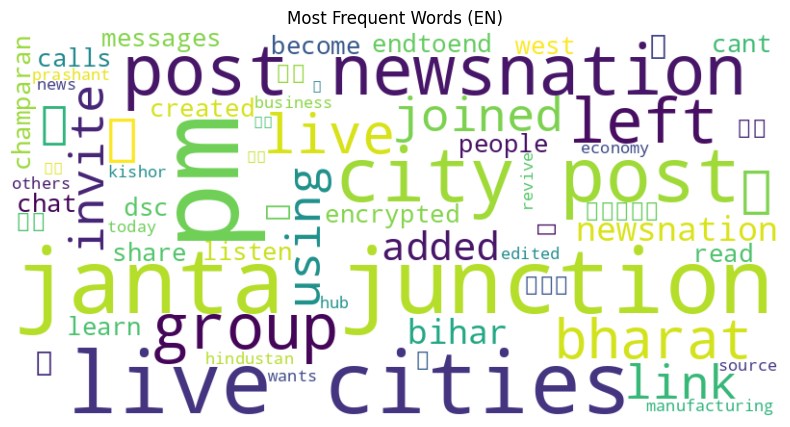

Hindi stopwords not found. Attempting to download...
Hindi stopwords downloaded successfully.
Hindi stopwords still not found. Skipping stopword removal for 'hi'.


[nltk_data] Error loading corpora/stopwords/hindi: Package
[nltk_data]     'corpora/stopwords/hindi' not found in index


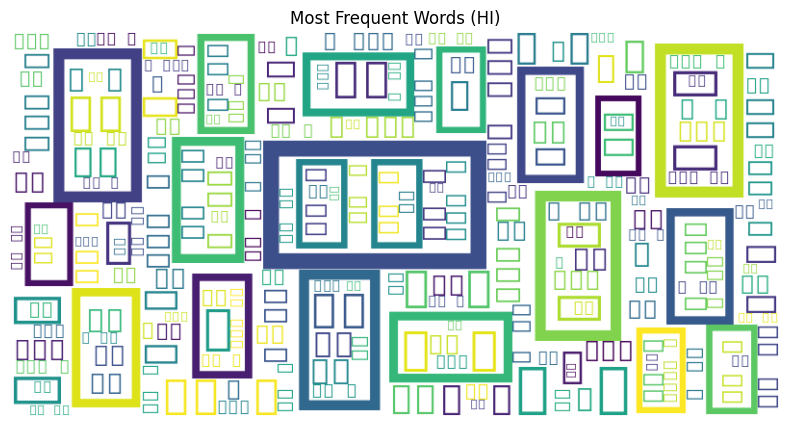


Detected other languages with significant text, but no specific stopword removal implemented:
- ID (997 characters)
- DE (259 characters)
- MR (858 characters)
- HU (206 characters)
- VI (223 characters)


In [ ]:
from nltk.corpus import stopwords
from langdetect import detect, LangDetectException
import collections # Import collections for defaultdict
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
import pandas as pd
import zipfile
import io
from google.colab import files
import os
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import emoji
from datetime import datetime
import nltk

# --- Function to parse the WhatsApp chat file ---
def parse_whatsapp_chat(file_content):
    """
    Parses a WhatsApp chat text file into a pandas DataFrame.
    Handles different date/time formats and multi-line messages.
    """
    lines = file_content.split('\n')
    messages = []
    message_buffer = []
    timestamp = None # Initialize timestamp to None
    # Updated regex to be more flexible with potential variations in date/time/separator
    date_time_pattern = re.compile(r'^\[?(\d{1,2}/\d{1,2}/\d{2,4}),?\s*(\d{1,2}:\d{2}(?::\d{2})?(?:\s*[AP]M)?)\]?\s*[-–]\s*([^:]+?):\s*(.*)$')


    for line in lines:
        match = date_time_pattern.match(line)
        if match:
            if message_buffer and timestamp is not None:
                full_message = " ".join(message_buffer).strip()
                # Ensure there's a colon before splitting
                if ':' in full_message:
                    author, msg = full_message.split(':', 1)
                    messages.append([timestamp, author.strip(), msg.strip()])
                message_buffer = []

            date_s, time_s, user, msg = match.groups()
            timestamp_str = f"{date_s} {time_s}".strip()
            ts = None
            # Adding more robust date format parsing
            fmts = [
                "%d/%m/%y %I:%M %p", "%m/%d/%y %I:%M %p",
                "%d/%m/%Y %I:%M %p", "%m/%d/%Y %I:%M %p",
                "%d/%m/%y %H:%M", "%m/%d/%y %H:%M",
                "%d/%m/%Y %H:%M", "%m/%d/%Y %H:%M",
                "%d/%m/%y %I:%M:%S %p", "%m/%d/%y %I:%M:%S %p",
                "%d/%m/%Y %I:%M:%S %p", "%m/%d/%Y %I:%M:%S %p",
                "%d/%m/%y %I:%M", "%m/%d/%y %I:%M",
                "%d/%m/%Y %I:%M", "%m/%d/%Y %I:%M",
            ]
            for fmt in fmts:
                try:
                    # Replace variations of am/pm to standardize for parsing
                    ts = datetime.strptime(timestamp_str.replace("am","AM").replace("pm","PM"), fmt)
                    break
                except ValueError:
                    pass # Try next format

            timestamp = ts
            message_buffer.append(f"{user}: {msg}") # Add the current message to the buffer

        else:
            # It's a continuation of the previous message
            message_buffer.append(line)

    # Add the last message in the buffer
    if message_buffer and timestamp is not None:
        full_message = " ".join(message_buffer).strip()
        if ':' in full_message:
            author, msg = full_message.split(':', 1)
            messages.append([timestamp, author.strip(), msg.strip()])

    df = pd.DataFrame(messages, columns=['timestamp', 'author', 'message'])
    # Remove media messages and messages that are only links
    df = df[df['message'] != '<Media omitted>']
    df = df[~df['message'].str.fullmatch(r'https?://\S+', na=False)] # Remove messages that are only links
    df = df.dropna(subset=['timestamp', 'author', 'message']) # Drop rows with any missing essential data

    print(f"Parsed {len(df)} messages.") # Add print statement to check parsed messages
    return df

# --- Function for Sentiment Analysis ---
def analyze_sentiment(df):
    """
    Performs sentiment analysis on the messages in the DataFrame.
    Detects language and uses VADER for English and TextBlob for Hindi.
    """
    if df.empty:
        print("DataFrame is empty. Skipping sentiment analysis.")
        return df

    analyzer = SentimentIntensityAnalyzer()
    sentiments = []
    for message in df['message']:
        detected_lang = 'en' # Default to English
        try:
            if isinstance(message, str) and message.strip(): # Ensure message is a non-empty string
                detected_lang = detect(message)
        except LangDetectException:
            pass # Use default 'en' if detection fails

        if detected_lang == 'en':
            # VADER for English sentiment
            final_score = analyzer.polarity_scores(message)['compound']
        elif detected_lang == 'hi':
            # TextBlob for Hindi sentiment (as a fallback)
            # TextBlob's sentiment for non-English is not highly accurate
            # but serves as a placeholder if a dedicated Hindi library isn't used
            try:
                blob_polarity = TextBlob(message).sentiment.polarity
                final_score = blob_polarity
            except Exception:
                 final_score = 0 # Default to neutral if TextBlob fails
        else:
             # For other languages, use TextBlob as a general fallback
             try:
                blob_polarity = TextBlob(message).sentiment.polarity
                final_score = blob_polarity
             except Exception:
                final_score = 0 # Default to neutral if TextBlob fails


        if final_score > 0.05:
            sentiments.append('Positive')
        elif final_score < -0.05:
            sentiments.append('Negative')
        else:
            sentiments.append('Neutral')

    df['sentiment'] = sentiments
    return df


# --- Function to generate and display the dashboard ---
def generate_dashboard(df):
    """
    Generates and displays the dashboard components using Plotly and Matplotlib.
    Includes language-specific word cloud generation.
    """
    if df.empty:
        print("No messages parsed. Cannot generate dashboard.")
        return

    print("--- WhatsApp Chat Analysis Dashboard ---")
    print("\n")

    # --- KPIs ---
    total_messages = len(df)
    total_participants = df['author'].nunique()
    # Check if there are any authors before finding the mode
    if not df['author'].mode().empty:
        most_active_user = df['author'].mode()[0]
        print(f"Total Messages: {total_messages}")
        print(f"Total Participants: {total_participants}")
        print(f"Most Active User: {most_active_user}")
    else:
        print("No authors found in the parsed messages.")
    print("\n" + "="*40 + "\n")


    # --- Sentiment Analysis Visualization ---
    sentiment_counts = df['sentiment'].value_counts(normalize=True) * 100
    fig_sentiment = px.bar(sentiment_counts,
                           x=sentiment_counts.index, y=sentiment_counts.values,
                           color=sentiment_counts.index,
                           labels={'x': 'Sentiment', 'y': 'Percentage (%)'},
                           title='Overall Sentiment Distribution',
                           color_discrete_map={'Positive':'green', 'Negative':'red', 'Neutral':'grey'})
    fig_sentiment.show()


    # --- Word Cloud (Language-Specific) ---
    # Accumulate text and detect language for each message
    language_texts = collections.defaultdict(list)
    for index, row in df.iterrows():
        message = row['message']
        detected_lang = 'unknown' # Default to unknown
        try:
            if isinstance(message, str) and message.strip():
                 # Try detecting language, limit to 'en' and 'hi' if possible for reliability
                 lang_probs = detect(message)
                 if lang_probs in ['en', 'hi']: # Directly use 'en' or 'hi' if detected
                     detected_lang = lang_probs
                 elif isinstance(lang_probs, list) and lang_probs: # Handle cases where detect returns a list of possibilities
                     # Prioritize 'en' and 'hi' if they are in the list
                     for prob in lang_probs:
                         if prob in ['en', 'hi']:
                             detected_lang = prob
                             break
                     if detected_lang not in ['en', 'hi'] and lang_probs[0] in ['en', 'hi']: # If not found, check the top probability
                          detected_lang = lang_probs[0]
                     elif detected_lang not in ['en', 'hi']: # If still not 'en' or 'hi', take the top one (could be noise)
                          detected_lang = lang_probs[0]
                 else: # If detect returns a single language not in ['en', 'hi']
                     detected_lang = lang_probs


        except LangDetectException:
            pass # detected_lang remains 'unknown'

        language_texts[detected_lang].append(message)

    # Combine texts by language
    combined_language_text = {lang: " ".join(texts) for lang, texts in language_texts.items()}

    # Define minimum text length to generate a word cloud
    min_text_length = 200 # Increased threshold for more meaningful clouds

    # Process and generate word cloud for each relevant language
    relevant_languages = ['en', 'hi'] # Languages for which we want to generate word clouds

    for lang in relevant_languages:
        text = combined_language_text.get(lang, "") # Get text for the language, default to empty string

        if text and len(text) > min_text_length: # Generate word cloud only if there is sufficient text
            # Remove URLs, emojis, non-alphanumeric/non-Hindi/non-whitespace characters, and numbers, convert to lowercase
            cleaned_text = re.sub(r'https?://\S+|[^a-zA-Z\s\u0900-\u097F]', '', text.lower())
            # Remove common non-meaningful words like "null", "deleted", "message"
            cleaned_text = re.sub(r'\b(null|deleted|message|media omitted)\b', '', cleaned_text)


            # Remove stop words based on language
            stop_words = set()
            try:
                if lang == 'en':
                    stop_words = set(stopwords.words('english'))
                elif lang == 'hi':
                    # Attempt to download Hindi stopwords if not found, then load
                    try:
                        nltk.data.find('corpora/stopwords/hindi')
                    except LookupError:
                        print("Hindi stopwords not found. Attempting to download...")
                        try:
                            nltk.download('corpora/stopwords/hindi', quiet=True) # Explicitly download Hindi stopwords
                            print("Hindi stopwords downloaded successfully.")
                        except Exception as e:
                            print(f"Error downloading Hindi stopwords: {e}")

                    try: # Try loading Hindi stopwords after ensuring download attempt
                        nltk.data.find('corpora/stopwords/hindi') # Check again after download attempt
                        stop_words = set(stopwords.words('hindi'))
                    except LookupError:
                         print(f"Hindi stopwords still not found. Skipping stopword removal for '{lang}'.")
                         stop_words = set() # Use empty set if stopwords not found


            except LookupError: # This outer LookupError might be less relevant now, but keep for safety
                 print(f"Stopwords for language '{lang}' not found generally. Skipping stopword removal for this language.")
                 stop_words = set() # Use empty set if stopwords not found


            words = cleaned_text.split()
            # Filter out single characters, stop words, and empty strings
            filtered_words = [word for word in words if word and word not in stop_words and len(word) > 1]
            processed_text = " ".join(filtered_words)

            if processed_text: # Generate word cloud only if there is processed text
                wordcloud = WordCloud(width=800, height=400, background_color="white").generate(processed_text)
                plt.figure(figsize=(10, 5))
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.title(f'Most Frequent Words ({lang.upper()})')
                plt.axis("off")
                plt.show()
            else:
                 print(f"No significant text in {lang.upper()} after cleaning and stopword removal to generate word cloud.")
        elif text and len(text) <= min_text_length:
             print(f"Insufficient text in {lang.upper()} ({len(text)} characters) to generate a meaningful word cloud.")
        else:
            print(f"No text data in {lang.upper()} to generate word cloud.")

    # Handle other detected languages if needed, or just report their presence
    other_languages = [lang for lang in combined_language_text.keys() if lang not in relevant_languages and len(combined_language_text[lang]) > min_text_length]
    if other_languages:
        print("\nDetected other languages with significant text, but no specific stopword removal implemented:")
        for lang in other_languages:
            print(f"- {lang.upper()} ({len(combined_language_text[lang])} characters)")


    # --- Most Active Users ---
    if not df['author'].empty: # Check if there are authors before plotting
        top_5_users = df['author'].value_counts().nlargest(5)
        fig_users = px.bar(top_5_users,
                           x=top_5_users.values, y=top_5_users.index,
                           orientation='h',
                           labels={'x': 'Number of Messages', 'y': 'User'},
                           title='Top 5 Most Active Users')
        fig_users.update_layout(yaxis={'categoryorder':'total ascending'})
        fig_users.show()
    else:
        print("No authors to display in Most Active Users chart.")


    # --- Message Volume by Hour ---
    if not df.empty: # Check if df is not empty before accessing dt accessor
        df['hour'] = df['timestamp'].dt.hour
        hourly_counts = df['hour'].value_counts().sort_index()
        fig_hourly = px.bar(hourly_counts, x=hourly_counts.index, y=hourly_counts.values,
                            labels={'x': 'Hour of Day', 'y': 'Number of Messages'},
                            title='Message Volume by Hour of Day')
        fig_hourly.show()
    else:
        print("No data to display in Message Volume by Hour chart.")


# --- Main execution block ---
uploaded = files.upload()

if not uploaded:
    print("No file uploaded. Please run the cell again and upload your ZIP file.")
else:
    zip_filename = list(uploaded.keys())[0]
    zip_file_bytes = uploaded[zip_filename]

    with zipfile.ZipFile(io.BytesIO(zip_file_bytes), 'r') as z:
        # Find the chat .txt file in the zip
        chat_file_name = None
        for name in z.namelist():
            if name.endswith('.txt'):
                chat_file_name = name
                break

        if chat_file_name:
            with z.open(chat_file_name) as chat_file:
                # The file is opened in binary mode, so decode it to utf-8
                file_content = chat_file.read().decode('utf-8')

                # Process the chat data
                df_chat = parse_whatsapp_chat(file_content)
                df_chat_sentiment = analyze_sentiment(df_chat)

                # Generate the dashboard
                generate_dashboard(df_chat_sentiment)
        else:
            print("Could not find a .txt file in the uploaded ZIP archive.")

**Reasoning**:
Despite attempts to download Hindi stopwords, NLTK still reports "Package 'corpora/stopwords/hindi' not found in index" and the Hindi word cloud shows incorrect characters, indicating the Hindi stopwords are not being loaded correctly. The text cleaning also needs further refinement to handle Hindi characters properly and remove remaining noise. I will adjust the Hindi stopword loading logic, ensure the text cleaning regex correctly preserves Hindi characters, and potentially use a different method for loading Hindi stopwords if the standard `stopwords.words('hindi')` continues to fail. I will also limit the languages for which word clouds are generated to only English and Hindi, as the others have insufficient text or are not the focus.



**Reasoning**:
The previous attempt still failed to load Hindi stopwords and the Hindi word cloud shows incorrect characters. The "Package 'corpora/stopwords/hindi' not found in index" error suggests an issue with the NLTK data structure or index after downloading. I will try a different approach to ensure the Hindi stopwords are available by explicitly checking and potentially downloading the full 'stopwords' corpus again if the specific Hindi resource isn't found, and then specifically load the Hindi stopwords. I will also ensure the text cleaning regex is correct for Hindi and specify a font that is known to support Hindi characters in the word cloud generation.

